
# CNN Cancer Detector
<img src="images/Melanoma.jpg" alt="Melanoma" width="500"/>

 ## Intro
<p>Skin cancer is the most common form of cancer, with 1 in 5 Americans developping it by the time they reach 70 years old. Over 2 people die of skin cancer in the US every hour.<sup>[1]</sup> 
Early detection is key in saving peoples lives with skin cancer, with the early detection 5 year survival rate being 99%<sup>[1]</sup>. Dermatologist have to look at patients one by one, and must assess by eye whether or not a blemish is malignant or benign. Dermatologist's have around a 66% accuracy rate in assessing 752 different skin diseases, while CNN's, such as the one detailed in *Dermatologist-level classification of skin cancer with deep neural networks* published in Nature have achieved greater accuracy levels then dermatologist's, around 72.1%<sup>[2]</sup>.<br>
<p>By converting cancer detection to easily deployable software, you could allow people to get accurate cancer testing at home, saving resources and time. By making cancer detection more accesible, people would be more likely to get tested, saving lives in the process. Below I will detail my process and results from a melanoma (the most deadly form of skin cancer) detector model using CNN's.<br>


In [2]:
#import necessary libraries
from torch import nn
from torchvision import models
#import imgaug as ia
#import imgaug.augmenters as iaa
from torchvision import datasets
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from torch import optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

In [5]:
#preprocess images

train_transform = transforms.Compose([transforms.RandomResizedCrop(299),
                                       transforms.RandomOrder([transforms.RandomChoice([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomRotation(30)]),
                                                               transforms.RandomPerspective()]),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
#make test transformer with no augmentation  
test_transform = transforms.Compose([transforms.Resize(299),
                                     transforms.CenterCrop(299),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])                                        

#make train,valid and test loaders
train_data = datasets.ImageFolder(root = 'train',transform = train_transform)
train_loader = DataLoader(train_data,shuffle = True,batch_size = 16,num_workers = 0)
valid_data =  datasets.ImageFolder(root = 'valid',transform = test_transform)
valid_loader = DataLoader(valid_data,shuffle = True,batch_size = 16,num_workers = 0)
test_data = datasets.ImageFolder(root = 'test',transform = test_transform)
test_loader = DataLoader(test_data,shuffle = True,batch_size = 16,num_workers = 0)

train_iter = iter(train_loader)
data,label = train_iter.next()
data = data.numpy()
loaders = {}
loaders['train'] = train_loader
loaders['valid'] = valid_loader
loaders['test'] = test_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

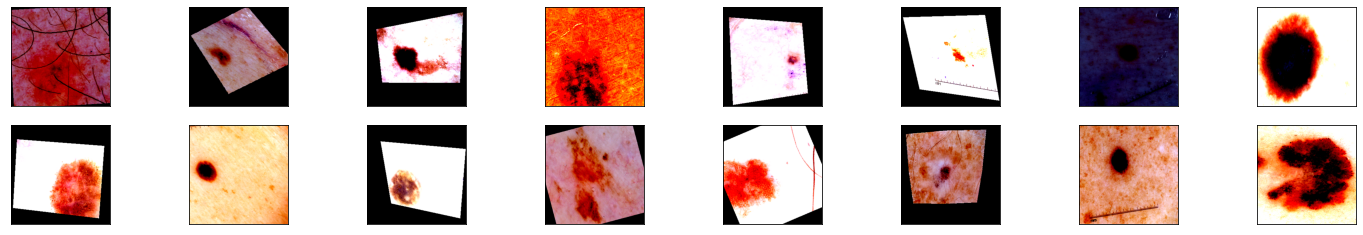

In [6]:
#visualize augmented training data
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
fig = plt.figure(figsize=(25, 4))
# display 32 images
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(data[idx])
  

<p>References:<br>
<p>[1] Skin Cancer Facts &amp; Statistics. (2020, July 10). Retrieved July 15, 2020, from https://www.skincancer.org/skin-cancer-information/skin-cancer-facts/<br>
<p>[2]Esteva, A., Kuprel, B., Novoa, R. A., Ko, J., Swetter, S. M., Blau, H. M., &amp; Thrun, S. (2017). Dermatologist-level classification of skin cancer with deep neural networks. Nature, 542(7639), 115-118. doi:10.1038/nature21056<br>


In [7]:
#load xception model
import pretrainedmodels

model_name = 'xception' # could be fbresnet152 or inceptionresnetv2
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')


In [8]:

#alter last layer to fit 3 classes.
model.last_linear = nn.Sequential(nn.Linear(2048,3),
                                )


In [9]:
#set up crtierion and optimizer
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [12]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path,early_stop_round):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    early_stopping =0 
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                output = model(data)
                loss = criterion(output,target)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            early_stopping=0
            print('SAVING MODEL')
        else:
            #if early we dont get a best score in 10
            early_stopping += 1
            if early_stopping >= early_stop_round:
                return model
    return model
            
    # return trained model


# train the model
#model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      #criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model = train(30,loaders,model,optimizer,criterion,True,'trained_model.pt',6)
model.load_state_dict(torch.load('trained_model.pt'))

Epoch: 1 	Training Loss: 0.803334 	Validation Loss: 1.156816
SAVING MODEL
Epoch: 2 	Training Loss: 0.726083 	Validation Loss: 0.875731
SAVING MODEL
Epoch: 3 	Training Loss: 0.721792 	Validation Loss: 0.997549
Epoch: 4 	Training Loss: 0.683414 	Validation Loss: 0.766247
SAVING MODEL
Epoch: 5 	Training Loss: 0.679408 	Validation Loss: 1.016184
Epoch: 6 	Training Loss: 0.659190 	Validation Loss: 1.061099
Epoch: 7 	Training Loss: 0.661217 	Validation Loss: 0.763438
SAVING MODEL
Epoch: 8 	Training Loss: 0.655981 	Validation Loss: 0.677458
SAVING MODEL
Epoch: 9 	Training Loss: 0.624416 	Validation Loss: 0.723502
Epoch: 10 	Training Loss: 0.616257 	Validation Loss: 0.723726
Epoch: 11 	Training Loss: 0.620198 	Validation Loss: 0.755620
Epoch: 12 	Training Loss: 0.616413 	Validation Loss: 0.666684
SAVING MODEL
Epoch: 13 	Training Loss: 0.596935 	Validation Loss: 0.667973
Epoch: 14 	Training Loss: 0.568352 	Validation Loss: 0.572739
SAVING MODEL
Epoch: 15 	Training Loss: 0.584016 	Validation Los

<All keys matched successfully>

In [14]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        with torch.no_grad():
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, model, criterion, True)

Test Loss: 0.695199


Test Accuracy: 72% (432/600)
